In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
from mlforecast.utils import generate_daily_series
# models
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

# data

In [17]:
series = generate_daily_series(
    n_series = 20,
    max_length = 100,
    n_static_features = 1,
    static_as_categorical = False,
    with_trend = True,
)
print(series.head())
print()
print(series.shape)
print()
print(series["unique_id"].value_counts())

  unique_id         ds           y  static_0
0     id_00 2000-01-01   17.519167        72
1     id_00 2000-01-02   87.799695        72
2     id_00 2000-01-03  177.442975        72
3     id_00 2000-01-04  232.704110        72
4     id_00 2000-01-05  317.510474        72

(1461, 4)

unique_id
id_09    100
id_01     97
id_00     94
id_18     89
id_05     89
id_17     88
id_10     86
id_13     74
id_14     74
id_11     73
id_19     73
id_08     71
id_07     69
id_15     62
id_06     59
id_12     56
id_04     53
id_03     53
id_16     51
id_02     50
Name: count, dtype: int64


# Forecasting

## model

In [19]:
fcst = MLForecast(
    models = [
        lgb.LGBMRegressor(random_state = 0, verbosity = -1),
        LinearRegression(),
    ],
    freq = "D",
    lags = [7, 14],
    lag_transforms = {
        1: [ExpandingMean()],
        7: [RollingMean(window_size = 28)]
    },
    date_features = ["dayofweek"],
    target_transforms = [Differences([1])],
)

## feature engine

In [20]:
prep_data = fcst.preprocess(series)
with pd.option_context("display.max_columns", None):
    print(prep_data.head(20))
    print()
    print(prep_data.shape)
    print()
    print(prep_data["unique_id"].value_counts())

   unique_id         ds           y  static_0        lag7       lag14   
35     id_00 2000-02-05 -430.702596        72 -454.058620 -456.530375  \
36     id_00 2000-02-06   87.790540        72   79.416692   70.494425   
37     id_00 2000-02-07   68.248825        72   84.021957   80.358734   
38     id_00 2000-02-08   63.141455        72   44.151060   67.095036   
39     id_00 2000-02-09   63.001354        72  105.237348   76.114648   
40     id_00 2000-02-10   95.211525        72   61.904630   79.455167   
41     id_00 2000-02-11   85.313695        72   55.861639   92.301047   
42     id_00 2000-02-12 -448.711752        72 -430.702596 -454.058620   
43     id_00 2000-02-13   72.815852        72   87.790540   79.416692   
44     id_00 2000-02-14   86.611835        72   68.248825   84.021957   
45     id_00 2000-02-15   58.372153        72   63.141455   44.151060   
46     id_00 2000-02-16   67.349966        72   63.001354  105.237348   
47     id_00 2000-02-17   75.665055        72   95.

## training

In [21]:
fcst.fit(series)

MLForecast(models=[LGBMRegressor, LinearRegression], freq=D, lag_features=['lag7', 'lag14', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size28'], date_features=['dayofweek'], num_threads=1)

## predict

In [22]:
predictions = fcst.predict(14)
predictions

,unique_id,ds,LGBMRegressor,LinearRegression
0,id_00,2000-04-04,299.923771,311.432371
1,id_00,2000-04-05,365.424147,379.466214
2,id_00,2000-04-06,432.562441,460.234028
3,id_00,2000-04-07,495.628000,524.278924
4,id_00,2000-04-08,60.786223,79.828767
...,...,...,...,...
275,id_19,2000-03-23,36.266780,28.333215
276,id_19,2000-03-24,44.370984,33.368228
277,id_19,2000-03-25,50.746222,38.613001
278,id_19,2000-03-26,58.906524,43.447398


## prediction

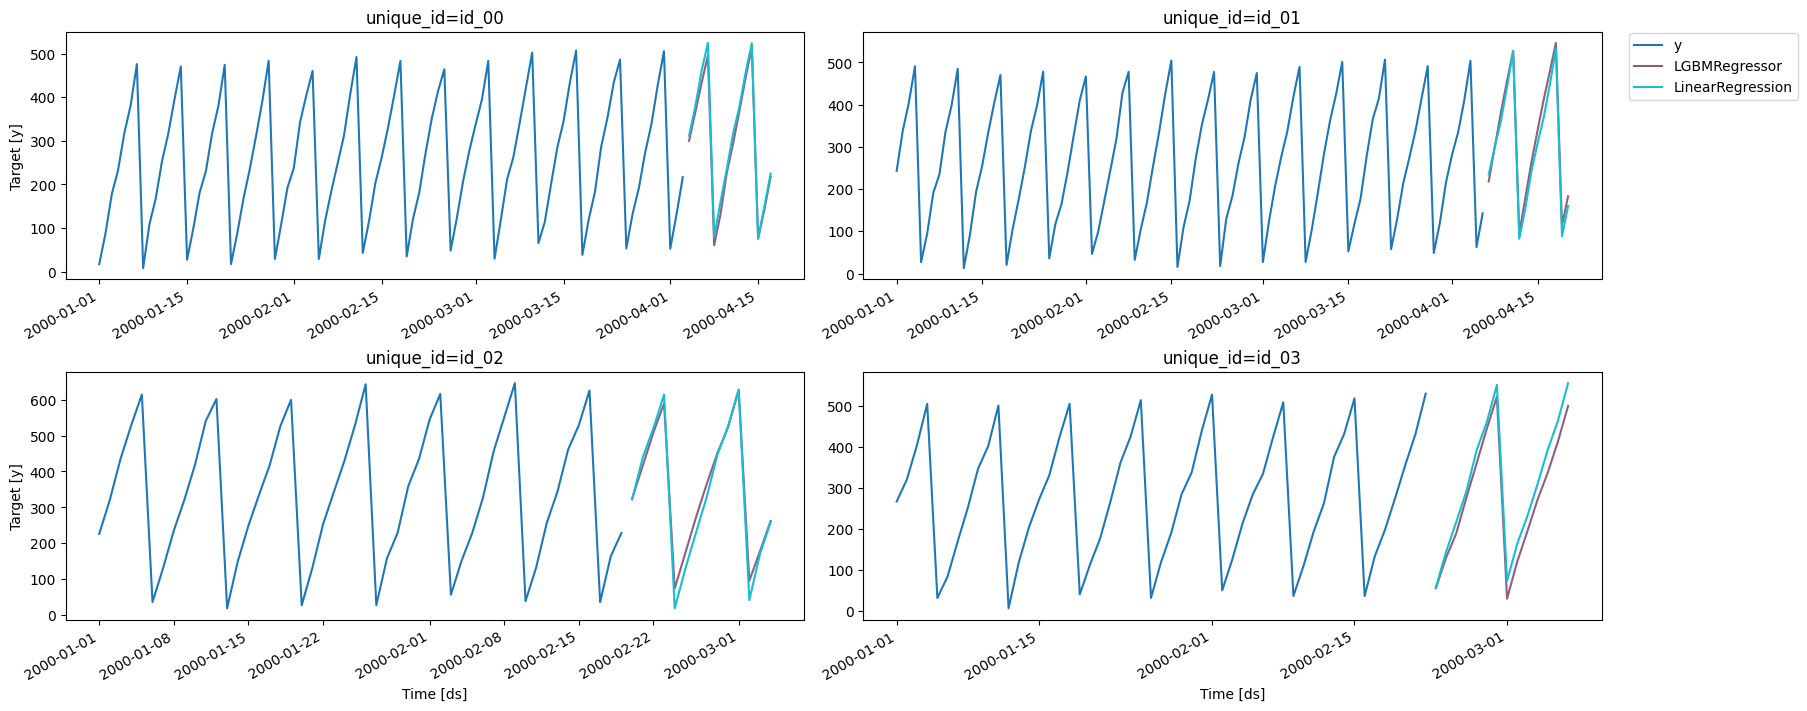

In [24]:
fig = plot_series(series, predictions, max_ids = 4, plot_random = False)
fig